### 数据分析与处理

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('../../dataset/LoanUsersData/data.csv', encoding='gbk')

# 数据处理
# 删除无关特征
df.drop(['Unnamed: 0', 'trade_no', 'bank_card_no', 'source', 'id_name'], inplace=True, axis=1)

# 数据类型转换
df['reg_preference_for_trad'].fillna('其他城市', inplace=True)
df['reg_preference_for_trad'].replace({
    '一线城市': 1,
    '二线城市': 2,
    '三线城市': 3,
    '境外': 4,
    '其他城市': 5
}, inplace=True)

# 处理日期类型数据
df.drop(['latest_query_time', 'loans_latest_time'], inplace=True, axis=1)

# 缺失值处理
df['student_feature'].fillna(0, inplace=True)
for i in df.columns:
    df[i].fillna(df[i].mode()[0], inplace=True)    # 用众数填充其他属性的缺失值

#  切分数据集
y = df['status']
x = df.drop('status', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2018)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(y_test.value_counts())

(3327, 82) (1427, 82) (3327,) (1427,)
0    1068
1     359
Name: status, dtype: int64


### 建模

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import Perceptron
import xgboost as xgb
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
import pandas as pd

# 数据标准化处理
features = x_train.columns
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

### 模型

#### 1.基本的分类器

In [8]:
import warnings

warnings.filterwarnings('ignore')

In [6]:
# 感知机
clf_pt = Perceptron(max_iter=50)
clf_pt.fit(x_train, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
# 逻辑回归
clf_lr = LogisticRegression()
clf_lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
# SVM
clf_svm = LinearSVC(C=1, loss='hinge')
clf_svm.fit(x_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [12]:
# decision tree
clf_dt = DecisionTreeClassifier()
clf_dt.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
# GaussianNB
clf_gnb = GaussianNB()
clf_gnb.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

#### 2.基于sklearn的集成学习

In [14]:
# 随机森林
clf_rf = RandomForestClassifier(random_state=2018, n_jobs=-1)
clf_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2018, verbose=0,
                       warm_start=False)

In [19]:
# GBDT
clf_gbdt = GradientBoostingClassifier()
clf_gbdt.fit(x_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [20]:
# Bagging
clf_bg = BaggingClassifier(base_estimator=LinearSVC(), n_estimators=60, max_samples=1.0, max_features=1.0, random_state=2018,
                          n_jobs=1, verbose=1)
clf_bg.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.0s finished


BaggingClassifier(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                           fit_intercept=True,
                                           intercept_scaling=1,
                                           loss='squared_hinge', max_iter=1000,
                                           multi_class='ovr', penalty='l2',
                                           random_state=None, tol=0.0001,
                                           verbose=0),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=60, n_jobs=1, oob_score=False,
                  random_state=2018, verbose=1, warm_start=False)

In [21]:
# Adaboost
clf_ab = AdaBoostClassifier(base_estimator=LinearSVC(), n_estimators=50, algorithm='SAMME')
clf_ab.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                            fit_intercept=True,
                                            intercept_scaling=1,
                                            loss='squared_hinge', max_iter=1000,
                                            multi_class='ovr', penalty='l2',
                                            random_state=None, tol=0.0001,
                                            verbose=0),
                   learning_rate=1.0, n_estimators=50, random_state=None)

#### 3. 大杀器

In [22]:
# xgboost
clf_xgb = xgb.XGBClassifier(max_depth=6, num_class =2,learning_rate=0.1, n_estimators=100, silent=True, objective='multi:softmax',
                        nthread=32, gamma=0.1, min_child_weight=3, max_delta_step=0, subsample=1, colsample_bytree=1,
                        colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=1000,
                        missing=None)
clf_xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=32, num_class=2, objective='multi:softmax',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=1000, silent=True, subsample=1, verbosity=1)

In [23]:
# lgbm
clf_lgbm = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31,  max_depth=-1, learning_rate=0.1, n_estimators=250,
                              max_bin=255, subsample_for_bin=200000, objective=None, min_split_gain=0.0, min_child_weight=0.001,
                              min_child_samples=20, subsample=1.0, subsample_freq=1, colsample_bytree=1.0, reg_alpha=0.0,
                              reg_lambda=0.5, random_state=None, n_jobs=-1, silent=True)
clf_lgbm.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_bin=255,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=250, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.5,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=1)

In [24]:
# 对11个模型进行预测
#对train
y_train_pt = clf_pt.predict(x_train)
y_train_lr = clf_lr.predict(x_train)
y_train_svm = clf_svm.predict(x_train)
y_train_dt = clf_dt.predict(x_train)
y_train_gnb = clf_gnb.predict(x_train)

y_train_rf = clf_rf.predict(x_train)
y_train_gbdt = clf_gbdt.predict(x_train)
y_train_bg = clf_bg.predict(x_train)
y_train_ab = clf_ab.predict(x_train)

y_train_xgb = clf_xgb.predict(x_train)
y_train_lgbm = clf_lgbm.predict(x_train)

#对test
y_test_pt = clf_pt.predict(x_test)
y_test_lr = clf_lr.predict(x_test)
y_test_svm = clf_svm.predict(x_test)
y_test_dt = clf_dt.predict(x_test)
y_test_gnb = clf_gnb.predict(x_test)

y_test_rf = clf_rf.predict(x_test)
y_test_gbdt = clf_gbdt.predict(x_test)
y_test_bg = clf_bg.predict(x_test)
y_test_ab = clf_ab.predict(x_test)

y_test_xgb = clf_xgb.predict(x_test)
y_test_lgbm = clf_lgbm.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


### 模型评估

In [27]:
# 混淆矩阵
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

def get_eval(y_train, y_test, y_train_pred, y_test_pred, model_name):
    train_dataList = []
    test_dataList = []
    print('for model {}:'.format(str(model_name)))
    train_dataList.append(str(model_name))
    test_dataList.append(str(model_name))
    train_dataList.append(str('train'))
    test_dataList.append(str('test'))
    
    # 混淆矩阵
    obj1 = confusion_matrix(y_train, y_train_pred)
    print('train_confusion_matrix\n', obj1)
    obj2 = confusion_matrix(y_test, y_test_pred)
    print('test_confusion_matrix\n', obj2)
    
    # print('accuracy:\n')
    # print('train:{}\n test:{}\n'.format(accuracy_score(y_train, y_train_pred), accuracy_score(y_test,y_test_pred)))
    train_dataList.append(accuracy_score(y_train,y_train_pred))
    test_dataList.append(accuracy_score(y_test,y_test_pred))
    
    train_dataList.append(precision_score(y_train,y_train_pred))
    test_dataList.append(precision_score(y_test,y_test_pred))

    train_dataList.append(recall_score(y_train,y_train_pred))
    test_dataList.append(recall_score(y_test,y_test_pred))

    train_dataList.append(f1_score(y_train,y_train_pred))
    test_dataList.append(f1_score(y_test,y_test_pred))

    train_dataList.append(roc_auc_score(y_train,y_train_pred))
    test_dataList.append(roc_auc_score(y_test,y_test_pred))
    
    return train_dataList,test_dataList

In [28]:
all_dataList = []
index = []
a1,a2 = get_eval(y_train,y_test,y_train_pt,y_test_pt,'感知机')
b1,b2 = get_eval(y_train,y_test,y_train_lr,y_test_lr,'逻辑回归')
c1,c2 = get_eval(y_train,y_test,y_train_svm,y_test_svm,'SVM')
d1,d2 = get_eval(y_train,y_test,y_train_dt,y_test_dt,'决策树')
e1,e2 = get_eval(y_train,y_test,y_train_gnb,y_test_gnb,'高斯朴素贝叶斯')
f1,f2 = get_eval(y_train,y_test,y_train_rf,y_test_rf,'随机森林')
g1,g2 = get_eval(y_train,y_test,y_train_gbdt,y_test_gbdt,'GBDT')
h1,h2 = get_eval(y_train,y_test,y_train_bg,y_test_bg,'Bagging')
i1,i2 = get_eval(y_train,y_test,y_train_ab,y_test_ab,'AdaBoosting')
j1,j2 = get_eval(y_train,y_test,y_train_xgb,y_test_xgb,'XGBoosting')
k1,k2 = get_eval(y_train,y_test,y_train_lgbm,y_test_lgbm,'lightGBM')

all_dataList = [a1, a2, b1, b2, c1, c2, d1, d2, e1, e2, f1, f2, g1, g2, h1, h2, i1, i2, j1, j2, k1, k2]
df_all = pd.DataFrame(all_dataList,columns=['model_name','dataset','accuracy','precision','recall','f1_score','AUC'])

for model 感知机:
train_confusion_matrix
 [[2074  419]
 [ 457  377]]
test_confusion_matrix
 [[848 220]
 [209 150]]
for model 逻辑回归:
train_confusion_matrix
 [[2359  134]
 [ 516  318]]
test_confusion_matrix
 [[993  75]
 [236 123]]
for model SVM:
train_confusion_matrix
 [[2423   70]
 [ 577  257]]
test_confusion_matrix
 [[1025   43]
 [ 273   86]]
for model 决策树:
train_confusion_matrix
 [[2493    0]
 [   0  834]]
test_confusion_matrix
 [[843 225]
 [211 148]]
for model 高斯朴素贝叶斯:
train_confusion_matrix
 [[1399 1094]
 [ 197  637]]
test_confusion_matrix
 [[952 116]
 [263  96]]
for model 随机森林:
train_confusion_matrix
 [[2493    0]
 [   0  834]]
test_confusion_matrix
 [[1012   56]
 [ 275   84]]
for model GBDT:
train_confusion_matrix
 [[2437   56]
 [ 402  432]]
test_confusion_matrix
 [[1003   65]
 [ 256  103]]
for model Bagging:
train_confusion_matrix
 [[2374  119]
 [ 537  297]]
test_confusion_matrix
 [[1000   68]
 [ 237  122]]
for model AdaBoosting:
train_confusion_matrix
 [[2362  131]
 [ 527  307]]
tes

In [29]:
%matplotlib notebook
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel = ('False Positive Rate')
    plt.ylabel = ('True Positive Rate')
    plt.show()
    plt.legend()

In [30]:
# 同时看train和test可以知道有没有过拟合
df_all

,model_name,dataset,accuracy,precision,recall,f1_score,AUC
0,感知机,train,0.736700,0.473618,0.452038,0.462577,0.641984
1,感知机,test,0.699369,0.405405,0.417827,0.411523,0.605917
2,逻辑回归,train,0.804629,0.703540,0.381295,0.494557,0.663772
3,逻辑回归,test,0.782060,0.621212,0.342618,0.441652,0.636197
4,SVM,train,0.805531,0.785933,0.308153,0.442722,0.640037
5,SVM,test,0.778556,0.666667,0.239554,0.352459,0.599646
6,决策树,train,1.000000,1.000000,1.000000,1.000000,1.000000
7,决策树,test,0.694464,0.396783,0.412256,0.404372,0.600791
8,高斯朴素贝叶斯,train,0.611963,0.367995,0.763789,0.496686,0.662480
9,高斯朴素贝叶斯,test,0.734408,0.452830,0.267409,0.336252,0.579398


In [34]:
# 画ROC曲线
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

def draw_roc(y_true, y_pred, label=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel = ('False Positive Rate')
    plt.ylabel = ('True Positive Rate')

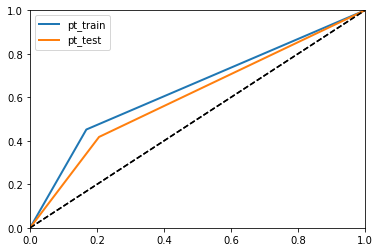

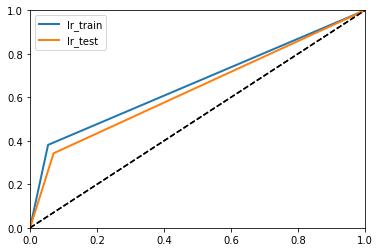

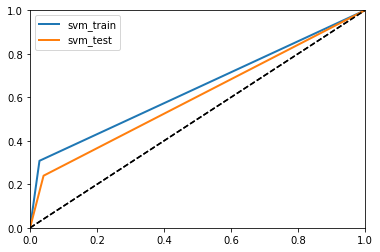

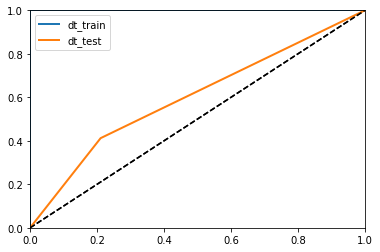

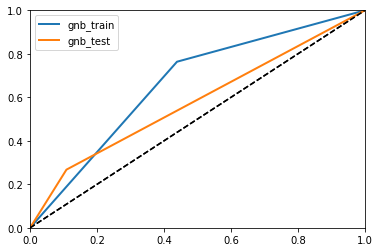

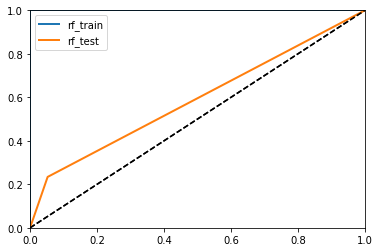

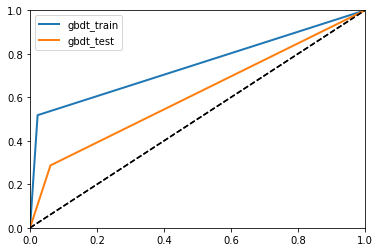

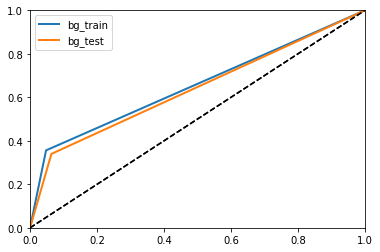

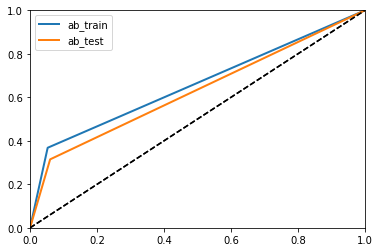

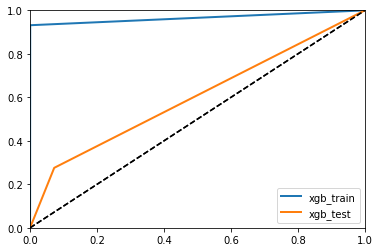

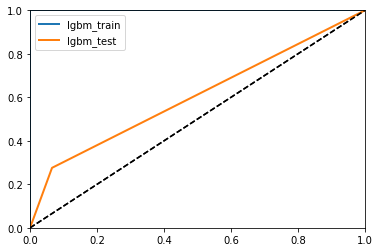

In [35]:
draw_roc(y_train,y_train_pt,'pt_train')
draw_roc(y_test,y_test_pt,'pt_test')
plt.legend()
plt.show()

draw_roc(y_train,y_train_lr,'lr_train')
draw_roc(y_test,y_test_lr,'lr_test')
plt.legend()
plt.show()

draw_roc(y_train,y_train_svm,'svm_train')
draw_roc(y_test,y_test_svm,'svm_test')
plt.legend()
plt.show()

draw_roc(y_train,y_train_dt,'dt_train')
draw_roc(y_test,y_test_dt,'dt_test')
plt.legend()
plt.show()

draw_roc(y_train,y_train_gnb,'gnb_train')
draw_roc(y_test,y_test_gnb,'gnb_test')
plt.legend()
plt.show()

draw_roc(y_train,y_train_rf,'rf_train')
draw_roc(y_test,y_test_rf,'rf_test')
plt.legend()
plt.show()

draw_roc(y_train,y_train_gbdt,'gbdt_train')
draw_roc(y_test,y_test_gbdt,'gbdt_test')
plt.legend()
plt.show()

draw_roc(y_train,y_train_bg,'bg_train')
draw_roc(y_test,y_test_bg,'bg_test')
plt.legend()
plt.show()

draw_roc(y_train,y_train_ab,'ab_train')
draw_roc(y_test,y_test_ab,'ab_test')
plt.legend()
plt.show()

draw_roc(y_train,y_train_xgb,'xgb_train')
draw_roc(y_test,y_test_xgb,'xgb_test')
plt.legend()
plt.show()

draw_roc(y_train,y_train_lgbm,'lgbm_train')
draw_roc(y_test,y_test_lgbm,'lgbm_test')
plt.legend()
plt.show()